# Analysing an issue in Dynamic Time Warping

In [11]:
import os
import glycoproteomics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
from pprint import pprint
matplotlib_inline.backend_inline.set_matplotlib_formats("png")
figure_size = (8, 4)
dpi = 100

spectra_directory = "/Users/jonesm5/Dropbox (The Francis Crick)/20210723_RT_alignment/"

reference_spectrum_filepath = "/Users/jonesm5/Dropbox (The Francis Crick)/PlasmaPooled_diann/20210702_Kuebler_2_P2_B1_PlasmaPooled_1.wiff.dia.extracted.txt"

Read in all spectra from the directory

In [12]:
sample_spectra = glycoproteomics.io.read_spectra_directory(spectra_directory)
for name, spectrum in sample_spectra.items():
    sample_ions = glycoproteomics.spectrum.list_ions(spectrum)
    print(name)
    print(sample_ions)

ref_spectrum = glycoproteomics.io.read_spectrum_file(reference_spectrum_filepath)
ref_ions = glycoproteomics.spectrum.list_ions(ref_spectrum)
print(reference_spectrum_filepath)
print(ref_ions)

20210702_Kuebler_137_P2_G8_CV-13_3.wiff.dia.extracted.txt
['138.055', '186.076', '204.087', '274.092', '292.103', '366.14', '657.235']
20210702_Kuebler_136_P2_D7_HD-2B_3.wiff.dia.extracted.txt
['138.055', '186.076', '204.087', '274.092', '292.103', '366.14', '657.235']
20210702_Kuebler_134_P2_A5_CV-24C_3.wiff.dia.extracted.txt
['138.055', '186.076', '204.087', '274.092', '292.103', '366.14', '657.235']
20210702_Kuebler_131_P2_F10_CV-59_3.wiff.dia.extracted.txt
['138.055', '186.076', '204.087', '274.092', '292.103', '366.14', '657.235']
20210702_Kuebler_132_P2_H6_CV-62_3.wiff.dia.extracted.txt
['138.055', '186.076', '204.087', '274.092', '292.103', '366.14', '657.235']
20210702_Kuebler_133_P2_G11_CV-64_3.wiff.dia.extracted.txt
['138.055', '186.076', '204.087', '274.092', '292.103', '366.14', '657.235']
20210702_Kuebler_135_P2_F9_CV-23_3.wiff.dia.extracted.txt
['138.055', '186.076', '204.087', '274.092', '292.103', '366.14', '657.235']
/Users/jonesm5/Dropbox (The Francis Crick)/PlasmaPoo

Bin the spectra to make them easier to work with and merge

In [13]:
rt_x_bin_size = 0.06
mz_y_bin_size = 2.0

binned_sample_spectra = {
    name: glycoproteomics.spectrum.bin(
        spectrum,
        rt_x_bin_size,
        mz_y_bin_size,
        np.mean)
    for name, spectrum in sample_spectra.items()
}
del(sample_spectra)

binned_ref_spectrum = glycoproteomics.spectrum.bin(
    ref_spectrum,
    rt_x_bin_size,
    mz_y_bin_size,
    np.mean
)
del(ref_spectrum)


Plot the spectra to visually inspect their differences. From above we can see that the ions measured in the reference spectrum are a superset of the ions measured in the samples, so we should use the sample ions from now on.

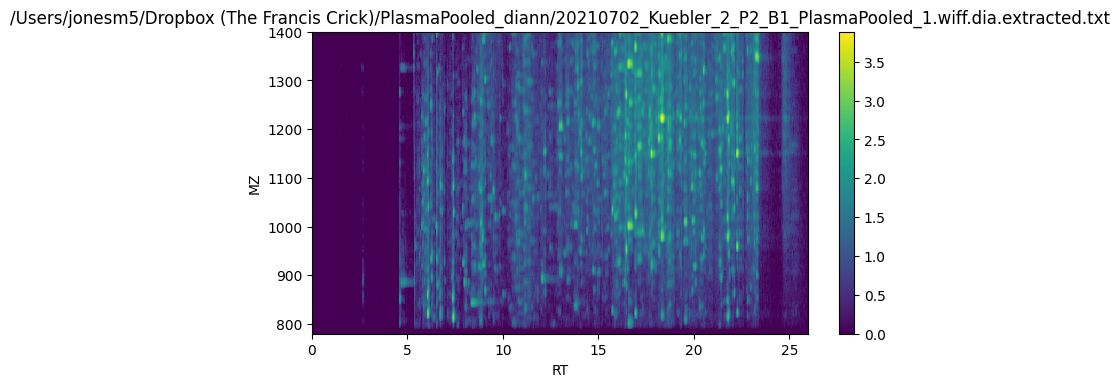

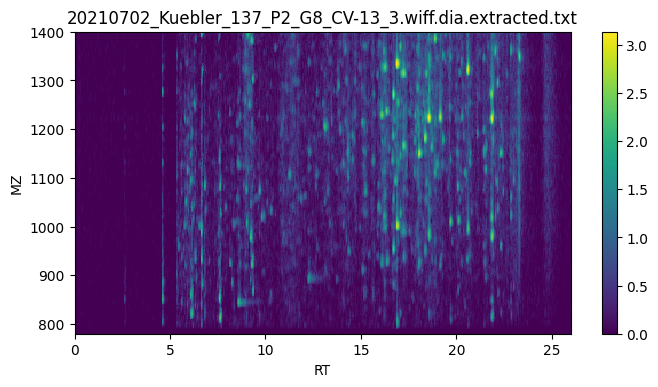

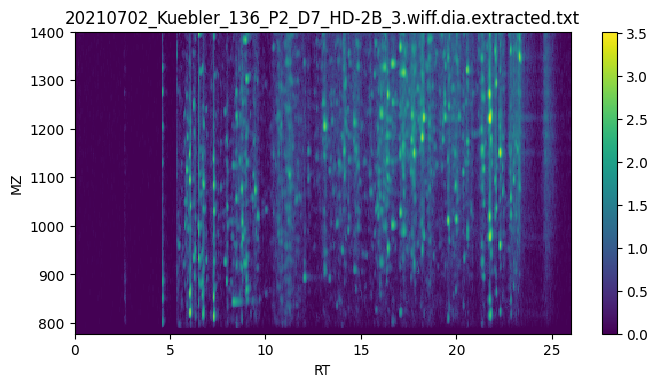

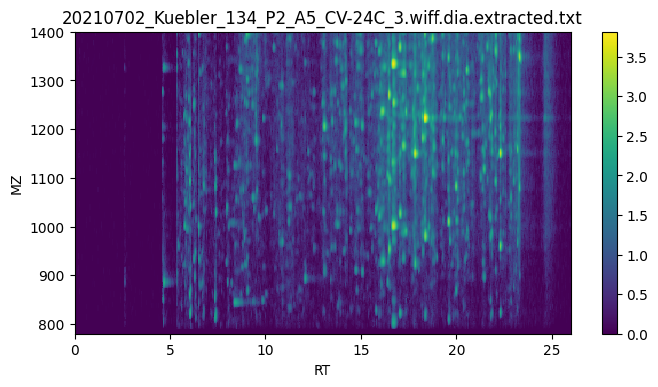

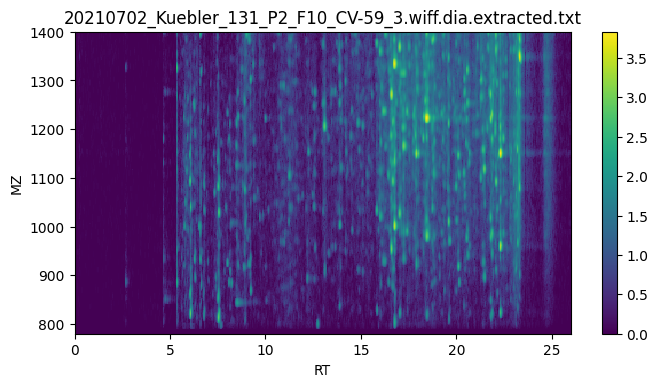

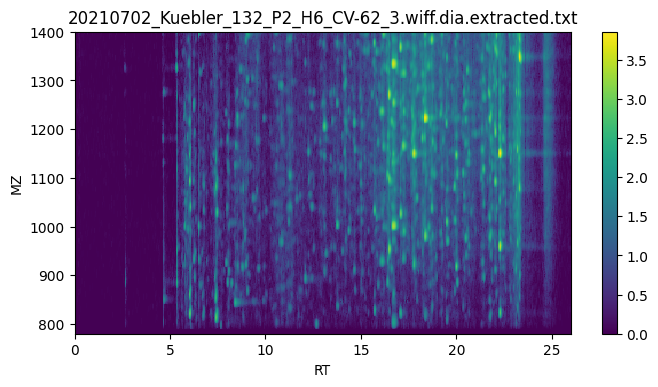

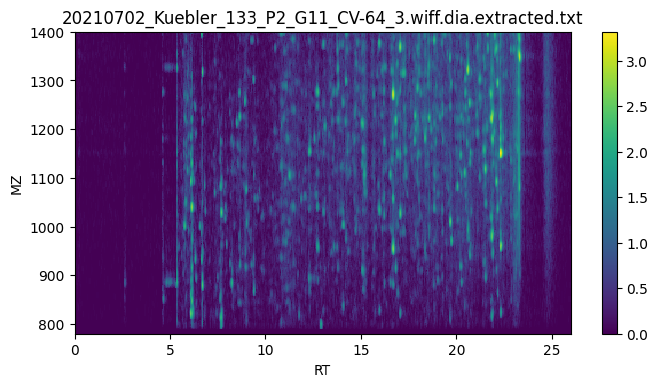

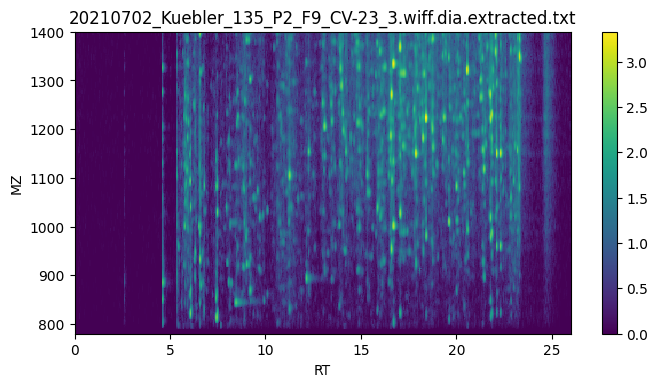

In [14]:
merged_ion_matrix, x_label, y_label = glycoproteomics.spectrum.to_matrix(
    binned_ref_spectrum,
    sample_ions
)
glycoproteomics.plotting.plot_ion_matrix(
    merged_ion_matrix,
    x_label,
    y_label,
    reference_spectrum_filepath,
    figure_size,
    dpi
)
plt.show()

for name, spectrum in binned_sample_spectra.items():
    merged_ion_matrix, x_label, y_label = glycoproteomics.spectrum.to_matrix(
        spectrum,
        sample_ions
    )
    glycoproteomics.plotting.plot_ion_matrix(
        merged_ion_matrix,
        x_label,
        y_label,
        name,
        figure_size,
        dpi
    )
    plt.show()

Merge the spectra. We don't need to worry about the different ions present in the samples and the reference, because the `align_rt` function determines which ions to use from the sample rather than the reference.

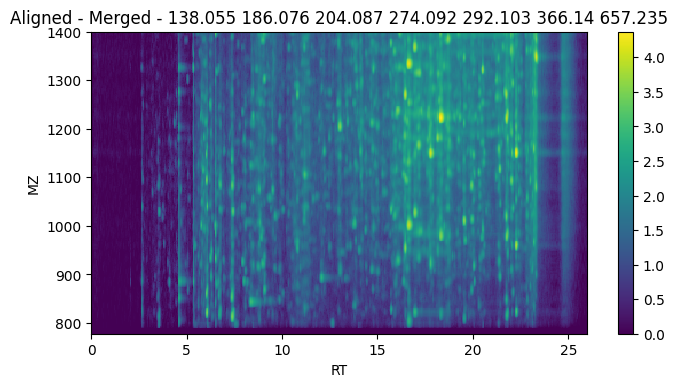

In [15]:
binned_aligned_sample_spectra = {}
rt_alignment_mappings = {}
for name, spectra in binned_sample_spectra.items():
    aligned_spectra, rt_alignment = glycoproteomics.spectrum.align_rt(
        spectra,
        binned_ref_spectrum,
        1,
        False
    )
    binned_aligned_sample_spectra[name] = aligned_spectra
    rt_alignment_mappings[name] = rt_alignment

merged_spectrum = glycoproteomics.spectrum.combine(
    binned_aligned_sample_spectra,
    np.sum
)
merged_ion_matrix, x_label, y_label = glycoproteomics.spectrum.to_matrix(
    merged_spectrum,
    sample_ions
)
glycoproteomics.plotting.plot_ion_matrix(
    merged_ion_matrix,
    x_label,
    y_label,
    "Aligned - Merged - " + " ".join(sample_ions),
    figure_size,
    dpi
)
plt.show()

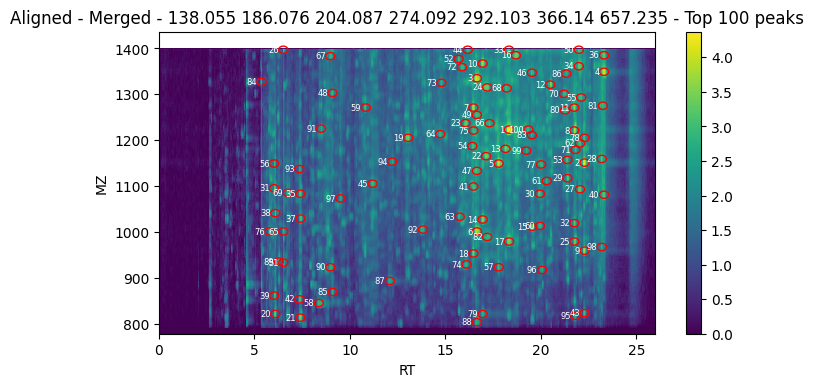

In [16]:
top_N_peaks = 100
x_radius = rt_x_bin_size * 4.0
y_radius = mz_y_bin_size * 4.0

peaks = glycoproteomics.peaks.find(
    merged_ion_matrix,
    x_label,
    y_label,
    top_N_peaks,
    x_radius,
    y_radius
)

glycoproteomics.plotting.plot_ion_matrix_with_peaks(
    merged_ion_matrix,
    x_label,
    y_label,
    peaks,
    x_radius,
    y_radius,
    "Aligned - Merged - {} - Top {} peaks".format(" ".join(sample_ions), top_N_peaks),
    figure_size,
    dpi
)
plt.show()

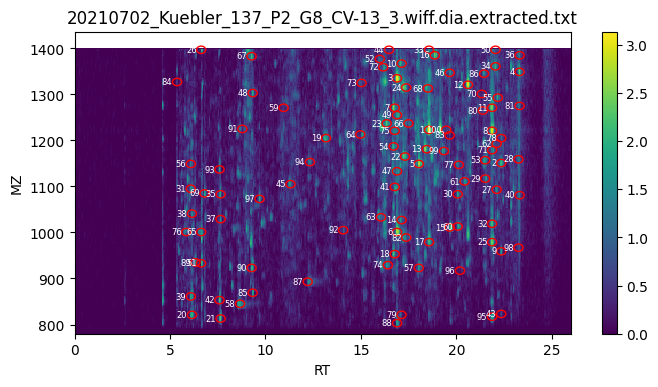

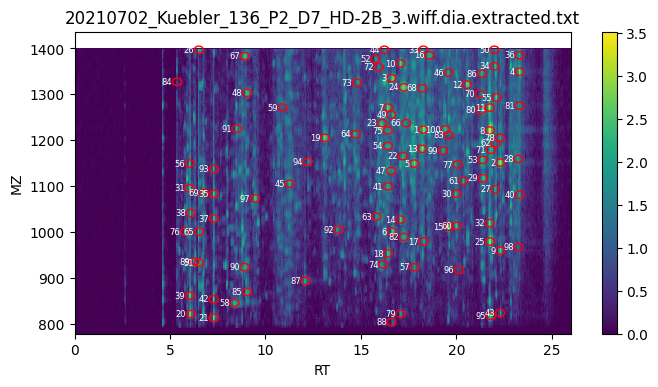

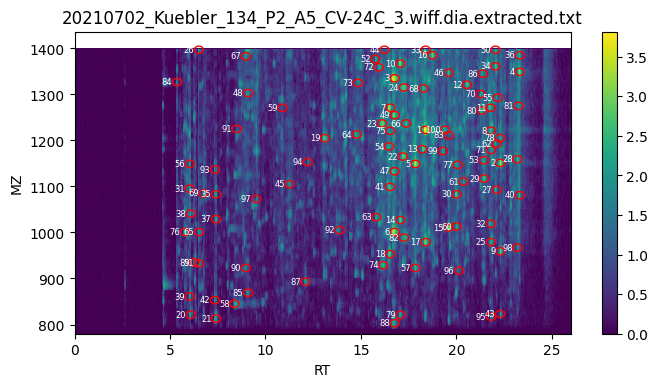

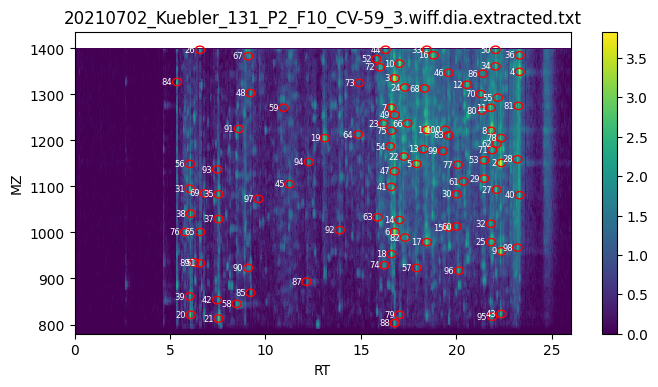

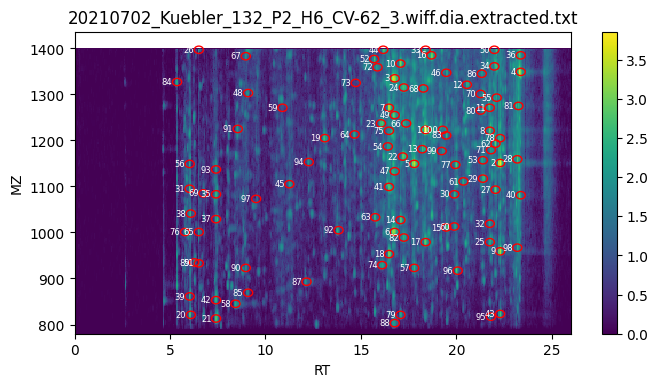

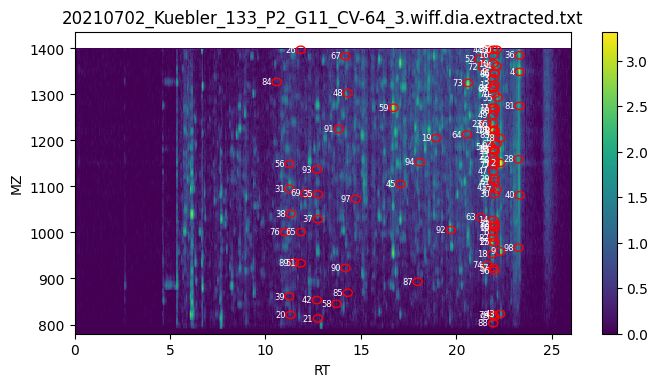

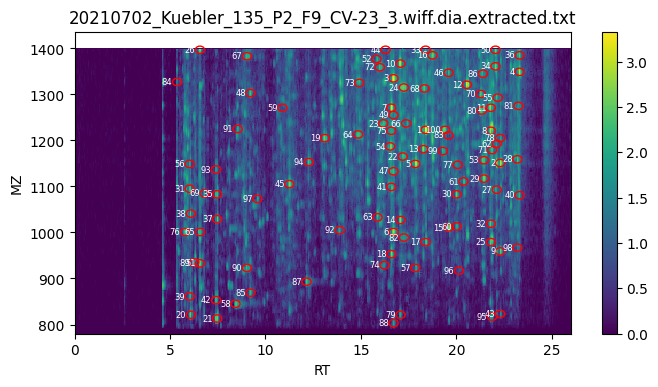

In [17]:
for name, spectrum in binned_sample_spectra.items():
    ion_matrix, x_label, y_label = glycoproteomics.spectrum.to_matrix(spectrum, sample_ions)
    moved_peaks = glycoproteomics.peaks.rt_move(peaks, rt_alignment_mappings[name])
    # Plot the individual spectrum with the merged peaks
    glycoproteomics.plotting.plot_ion_matrix_with_peaks(
        ion_matrix,
        x_label,
        y_label,
        moved_peaks,
        x_radius,
        y_radius,
        name,
        figure_size,
        dpi
    )
    plt.show()


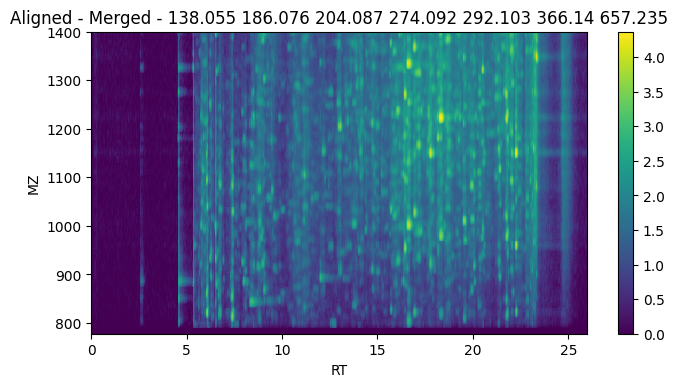

In [18]:
binned_aligned_sample_spectra = {}
rt_alignment_mappings = {}
for name, spectra in binned_sample_spectra.items():
    aligned_spectra, rt_alignment = glycoproteomics.spectrum.align_rt(
        spectra,
        binned_ref_spectrum,
        1,
        True
    )
    binned_aligned_sample_spectra[name] = aligned_spectra
    rt_alignment_mappings[name] = rt_alignment

merged_spectrum = glycoproteomics.spectrum.combine(
    binned_aligned_sample_spectra,
    np.sum
)
merged_ion_matrix, x_label, y_label = glycoproteomics.spectrum.to_matrix(
    merged_spectrum,
    sample_ions
)
glycoproteomics.plotting.plot_ion_matrix(
    merged_ion_matrix,
    x_label,
    y_label,
    "Aligned - Merged - " + " ".join(sample_ions),
    figure_size,
    dpi
)
plt.show()

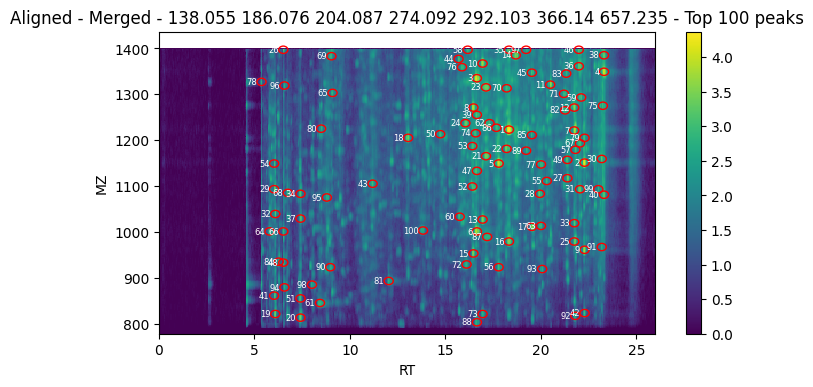

In [19]:
top_N_peaks = 100
x_radius = rt_x_bin_size * 4.0
y_radius = mz_y_bin_size * 4.0

peaks = glycoproteomics.peaks.find(
    merged_ion_matrix,
    x_label,
    y_label,
    top_N_peaks,
    x_radius,
    y_radius
)

glycoproteomics.plotting.plot_ion_matrix_with_peaks(
    merged_ion_matrix,
    x_label,
    y_label,
    peaks,
    x_radius,
    y_radius,
    "Aligned - Merged - {} - Top {} peaks".format(" ".join(sample_ions), top_N_peaks),
    figure_size,
    dpi
)
plt.show()

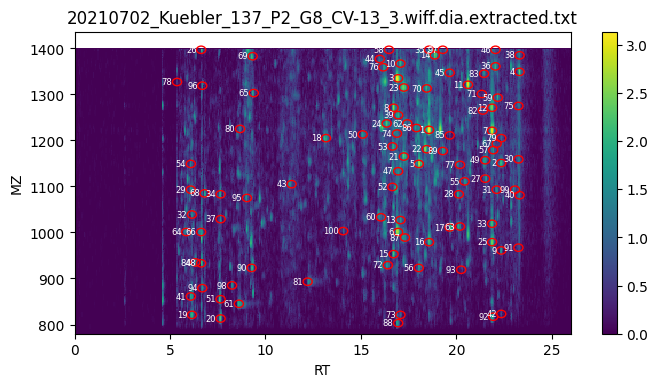

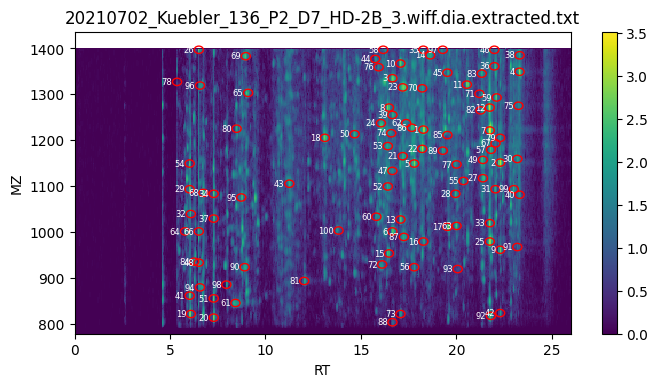

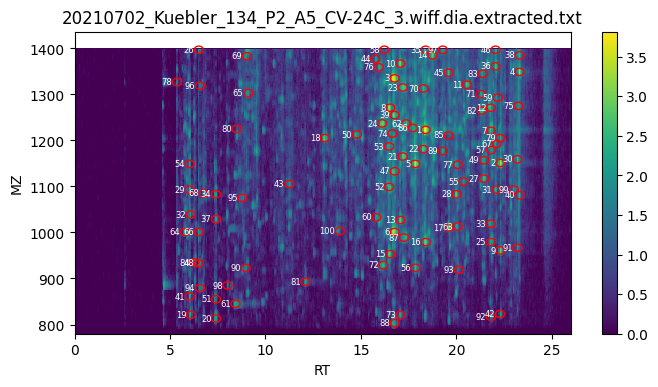

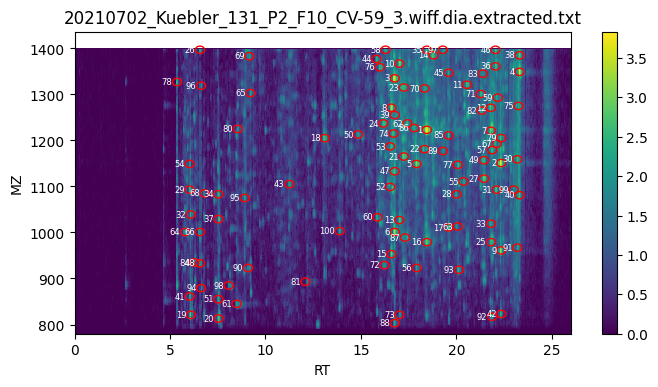

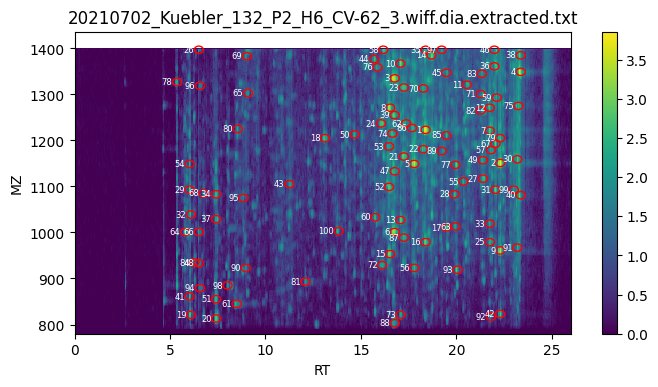

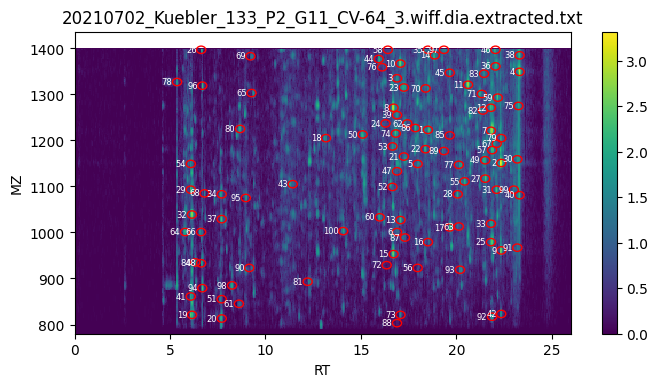

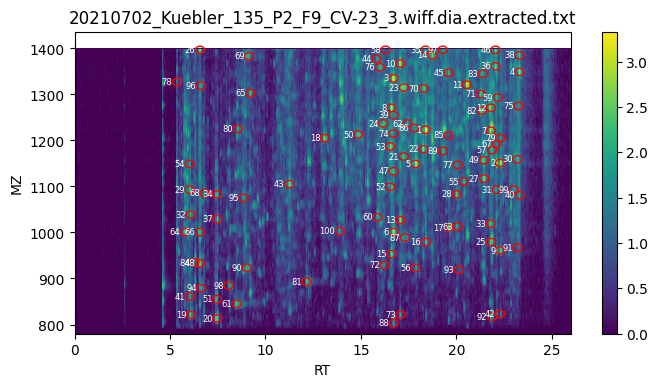

In [20]:
for name, spectrum in binned_sample_spectra.items():
    ion_matrix, x_label, y_label = glycoproteomics.spectrum.to_matrix(spectrum, sample_ions)
    moved_peaks = glycoproteomics.peaks.rt_move(peaks, rt_alignment_mappings[name])
    # Plot the individual spectrum with the merged peaks
    glycoproteomics.plotting.plot_ion_matrix_with_peaks(
        ion_matrix,
        x_label,
        y_label,
        moved_peaks,
        x_radius,
        y_radius,
        name,
        figure_size,
        dpi
    )
    plt.show()
